In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler

import tensorflow as ft
from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

2023-02-20 10:02:22.414852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from meli.utils import split_data, split_data_on_index
from meli.plot import (correlation_matrix, 
                       pair_plot,
                       plot_attributes,
                       pair_plot_attributes_target,
                       make_confusion_matrix,
                       xgb_learning_curves)

In [4]:
%matplotlib inline

In [5]:
plt.style.use("seaborn-whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)

In [6]:
df = pd.read_csv("../data/raw/full_devices.csv", 
                 index_col=["device", "date"],
                 parse_dates=["date"],
                 encoding_errors="replace")

In [7]:
df = df.sort_index()

In [8]:
df.head(10)

failure  attribute1  attribute2  attribute3  attribute4  \
device   date                                                                  
S1F01085 2015-01-01        0   215630672          56           0          52   
         2015-01-02        0     1650864          56           0          52   
         2015-01-03        0   124017368          56           0          52   
         2015-01-04        0   128073224          56           0          52   
         2015-01-05        0    97393448          56           0          52   
         2015-01-06        0   128832128          56           0          52   
S1F013BB 2015-05-06        0    14533968           0           0           0   
         2015-05-07        0    46202296           0           0           0   
         2015-05-08        0   214383720           0           0           0   
         2015-05-09        0   243346080           0           0           0   

                     attribute5  attribute6  attribute7  attribute8  \
device   date                                                         
S1F01085 2015-01-01           6      407438           0           0   
         2015-01-02           6      407438           0           0   
         2015-01-03           6      407438           0           0   
         2015-01-04           6      407439           0           0   
         2015-01-05           6      408114           0           0   
         2015-01-06           6      409404           0           0   
S1F013BB 2015-05-06           5      688952           0           0   
         2015-05-07           5      688952           0           0   
         2015-05-08           5      688964           0           0   
         2015-05-09           5      689035           0           0   

                     attribute9  
device   date                    
S1F01085 2015-01-01           7  
         2015-01-02           7  
         2015-01-03           7  
         2015-01-04           7  
         2015-01-05           7  
         2015-01-06           7  
S1F013BB 2015-05-06           0  
         2015-05-07           0  
         2015-05-08           0  
         2015-05-09           0

In [9]:
target = "failure"
test_size = 0.2
random_state = 1

# Index analysis

In [10]:
df.index.is_unique

False

In [11]:
df.groupby(["device", "date"]).count().sort_values(by=target, ascending=False).head()

failure  attribute1  attribute2  attribute3  attribute4  \
device   date                                                                  
S1F0R4Q8 2015-07-10        2           2           2           2           2   
S1F01085 2015-01-01        1           1           1           1           1   
W1F17DKS 2015-05-05        1           1           1           1           1   
         2015-05-03        1           1           1           1           1   
         2015-05-02        1           1           1           1           1   

                     attribute5  attribute6  attribute7  attribute8  \
device   date                                                         
S1F0R4Q8 2015-07-10           2           2           2           2   
S1F01085 2015-01-01           1           1           1           1   
W1F17DKS 2015-05-05           1           1           1           1   
         2015-05-03           1           1           1           1   
         2015-05-02           1           1           1           1   

                     attribute9  
device   date                    
S1F0R4Q8 2015-07-10           2  
S1F01085 2015-01-01           1  
W1F17DKS 2015-05-05           1  
         2015-05-03           1  
         2015-05-02           1

In [12]:
df.loc[("S1F0R4Q8", "2015-07-10")]

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
date,,,,,,,,,,
2015-07-10,0,192721392,0,0,0,8,213700,0,0,0
2015-07-10,0,192721392,0,0,0,8,213700,0,0,0


In [13]:
df.shape

(124494, 10)

In [14]:
df = df[~df.index.duplicated()]

In [15]:
df.shape

(124493, 10)

In [16]:
df.loc[("S1F0R4Q8", "2015-07-10")]

failure               0
attribute1    192721392
attribute2            0
attribute3            0
attribute4            0
attribute5            8
attribute6       213700
attribute7            0
attribute8            0
attribute9            0
Name: (S1F0R4Q8, 2015-07-10 00:00:00), dtype: int64

# Basic analysis

In [17]:
df.value_counts(target)

failure
0    124387
1       106
dtype: int64

In [18]:
df.dtypes

failure       int64
attribute1    int64
attribute2    int64
attribute3    int64
attribute4    int64
attribute5    int64
attribute6    int64
attribute7    int64
attribute8    int64
attribute9    int64
dtype: object

In [19]:
int_cols = [col for col in df.select_dtypes('int64') if col != target]
for col in int_cols:
    df[col] = df[col].astype(np.float64)

In [20]:
df.dtypes

failure         int64
attribute1    float64
attribute2    float64
attribute3    float64
attribute4    float64
attribute5    float64
attribute6    float64
attribute7    float64
attribute8    float64
attribute9    float64
dtype: object

In [21]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124493.000000,1.244930e+05,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000
mean,0.000851,1.223875e+08,159.486043,9.940535,1.741134,14.222719,260173.031022,0.292531,0.292531,12.451624
std,0.029167,7.045934e+07,2179.666438,185.748065,22.908598,15.943082,99151.389285,7.436954,7.436954,191.426389
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128346e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227971e+08,0.000000,0.000000,0.000000,10.000000,249800.000000,0.000000,0.000000,0.000000
75%,0.000000,1.833091e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


<AxesSubplot:>

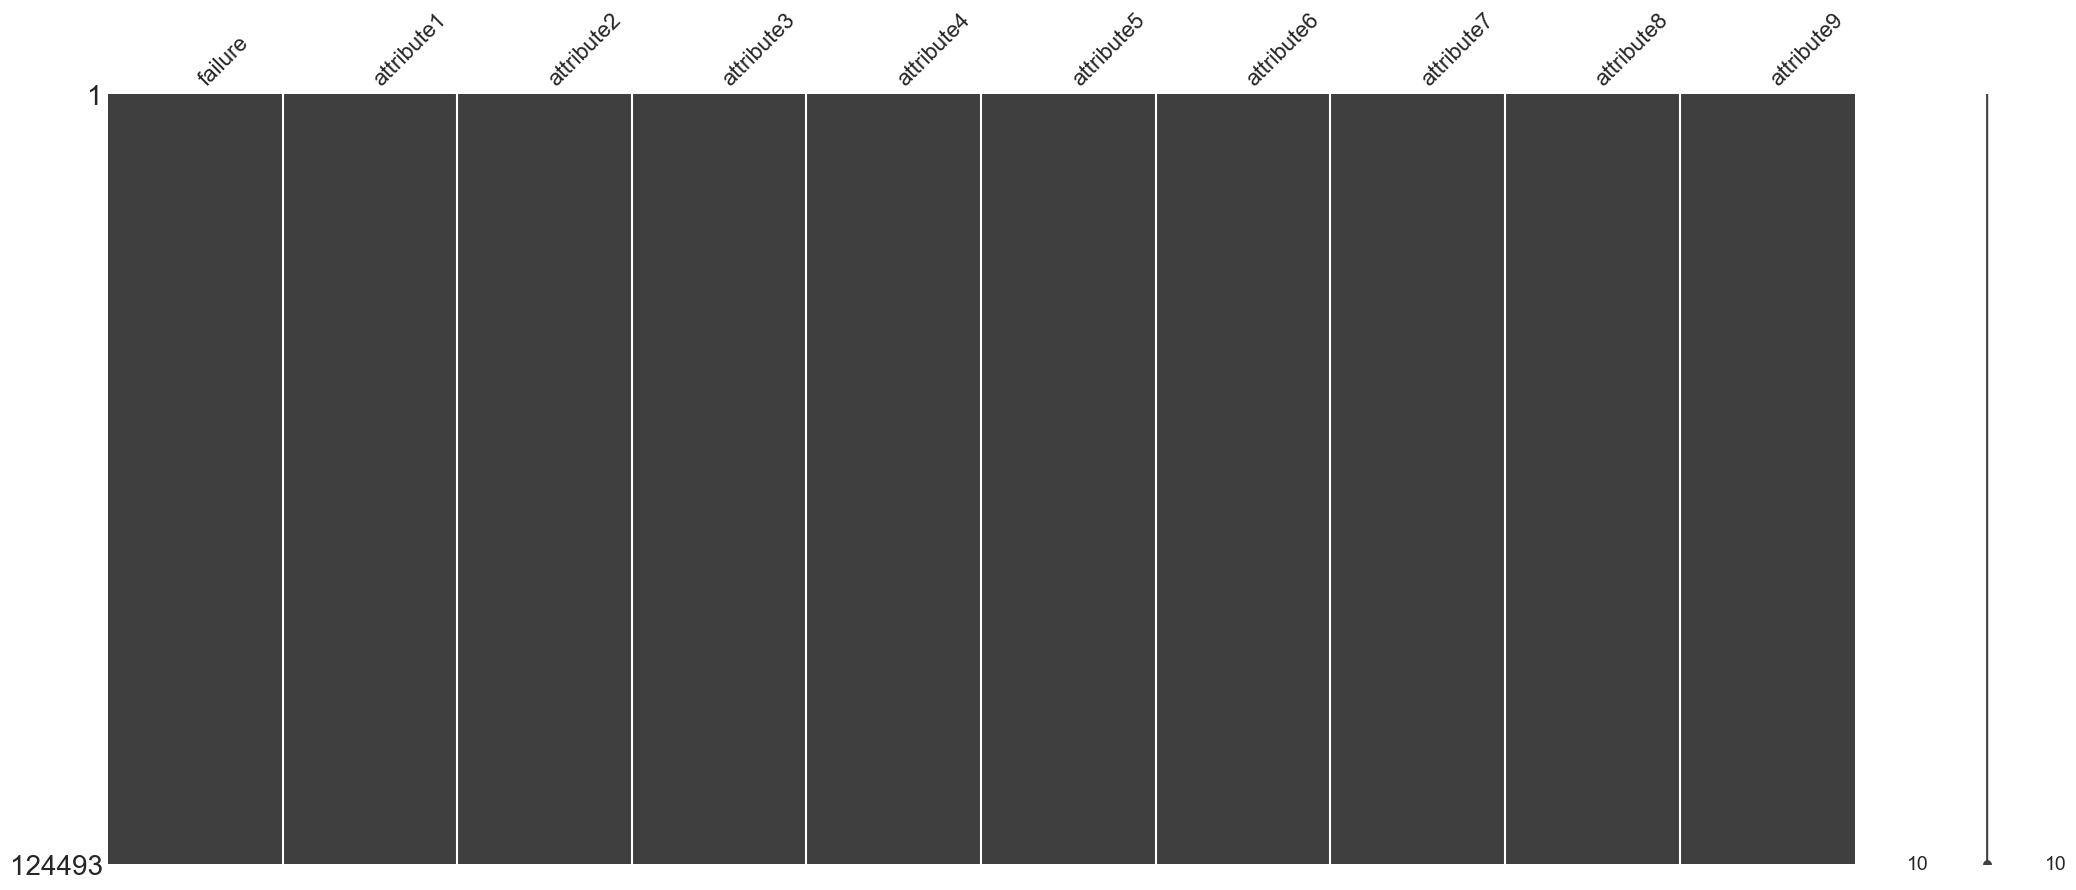

In [22]:
msno.matrix(df)

# Target analysis

In [23]:
df[df[target]==1].shape

(106, 10)

In [24]:
df[df[target]==1].sample(10)

,,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
device,date,,,,,,,,,,
W1F19BPT,2015-03-04,1,147855008.0,16.0,0.0,0.0,23.0,45.0,0.0,0.0,0.0
W1F0Z3KR,2015-06-10,1,34532320.0,0.0,0.0,1.0,8.0,142037.0,0.0,0.0,0.0
S1F0RRB1,2015-01-05,1,48467332.0,64776.0,0.0,841.0,8.0,39267.0,56.0,56.0,1.0
W1F0FW0S,2015-01-28,1,229400712.0,0.0,0.0,39.0,64.0,200990.0,8.0,8.0,2.0
W1F0Q8FH,2015-03-19,1,192488552.0,0.0,0.0,21.0,41.0,242150.0,8.0,8.0,10.0
W1F1230J,2015-01-14,1,220461296.0,0.0,0.0,0.0,14.0,325125.0,0.0,0.0,0.0
S1F0LCTV,2015-01-26,1,47001646.0,0.0,0.0,7.0,12.0,468887.0,0.0,0.0,0.0
Z1F1653X,2015-05-08,1,68239312.0,0.0,0.0,95.0,8.0,192558.0,16.0,16.0,0.0
S1F0RR35,2015-05-08,1,130852088.0,200.0,0.0,0.0,16.0,285511.0,0.0,0.0,0.0


In [25]:
# each device has failed only once
df.groupby("device").sum()[target].sort_values(ascending=False).head()

device
Z1F0LSNZ    1
W1F1230J    1
Z1F0P5D9    1
S1F0L0DW    1
W1F1DQN8    1
Name: failure, dtype: int64

In [26]:
# the failure is the last data point for each device that has failed
df[df[target] == 1].groupby("device").last()[target].sort_values(ascending=True).head()

device
S1F023H2    1
W1F1BS0H    1
W1F1BFP5    1
W1F19BPT    1
W1F15S4D    1
Name: failure, dtype: int64

# Features analysis

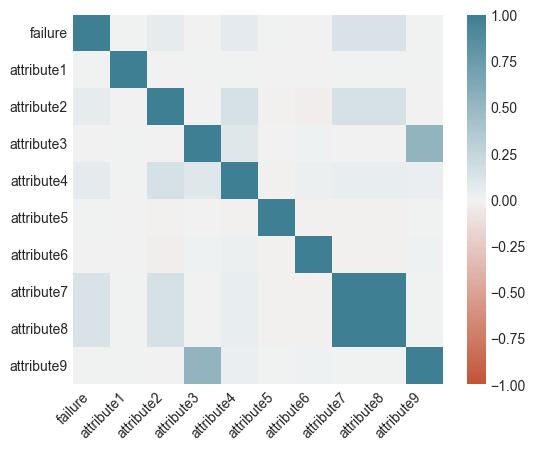

In [27]:
correlation_matrix(df)

In [28]:
(df["attribute7"] == df["attribute8"]).sum(), df.shape[0]

(124493, 124493)

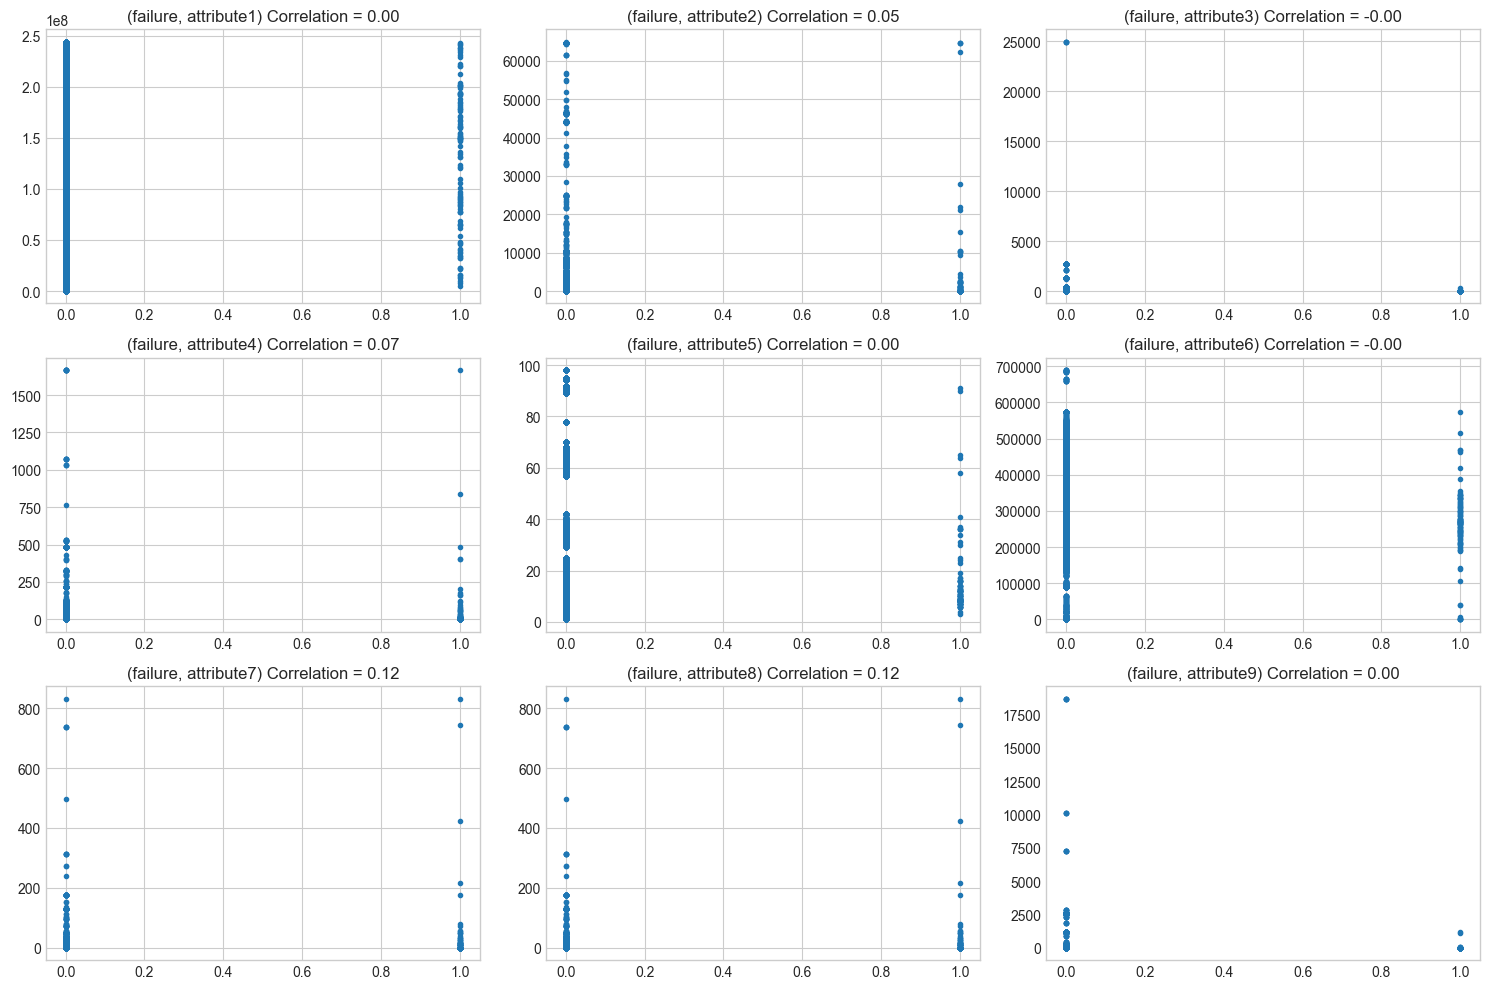

In [29]:
pair_plot_attributes_target(df)

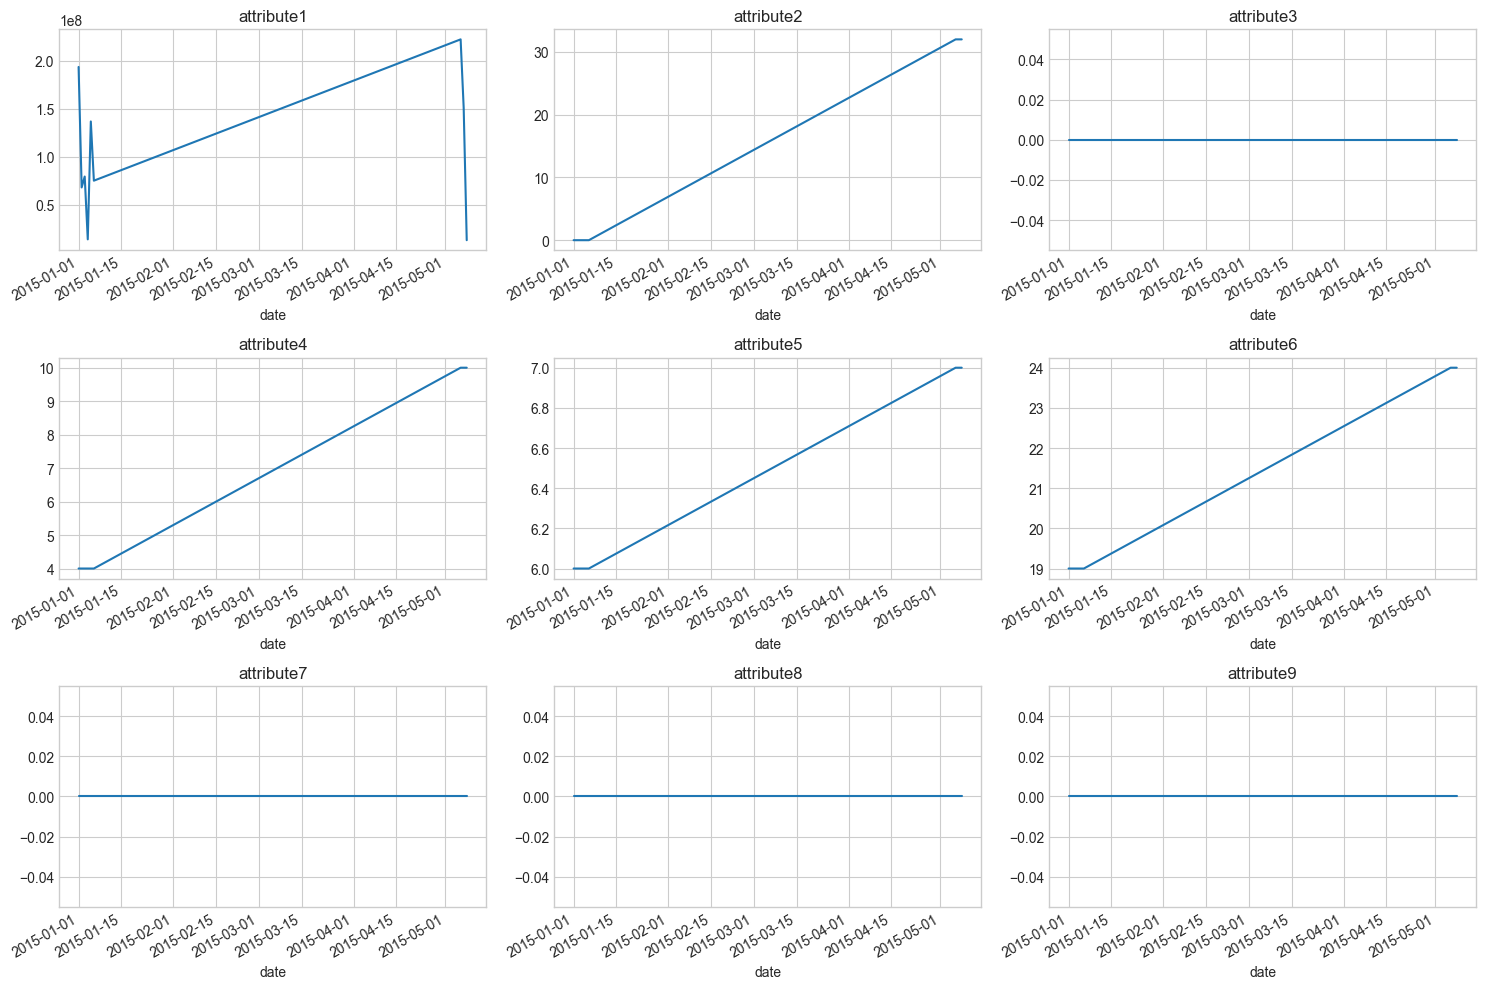

In [30]:
plot_attributes(df, "Z1F1AG5N")

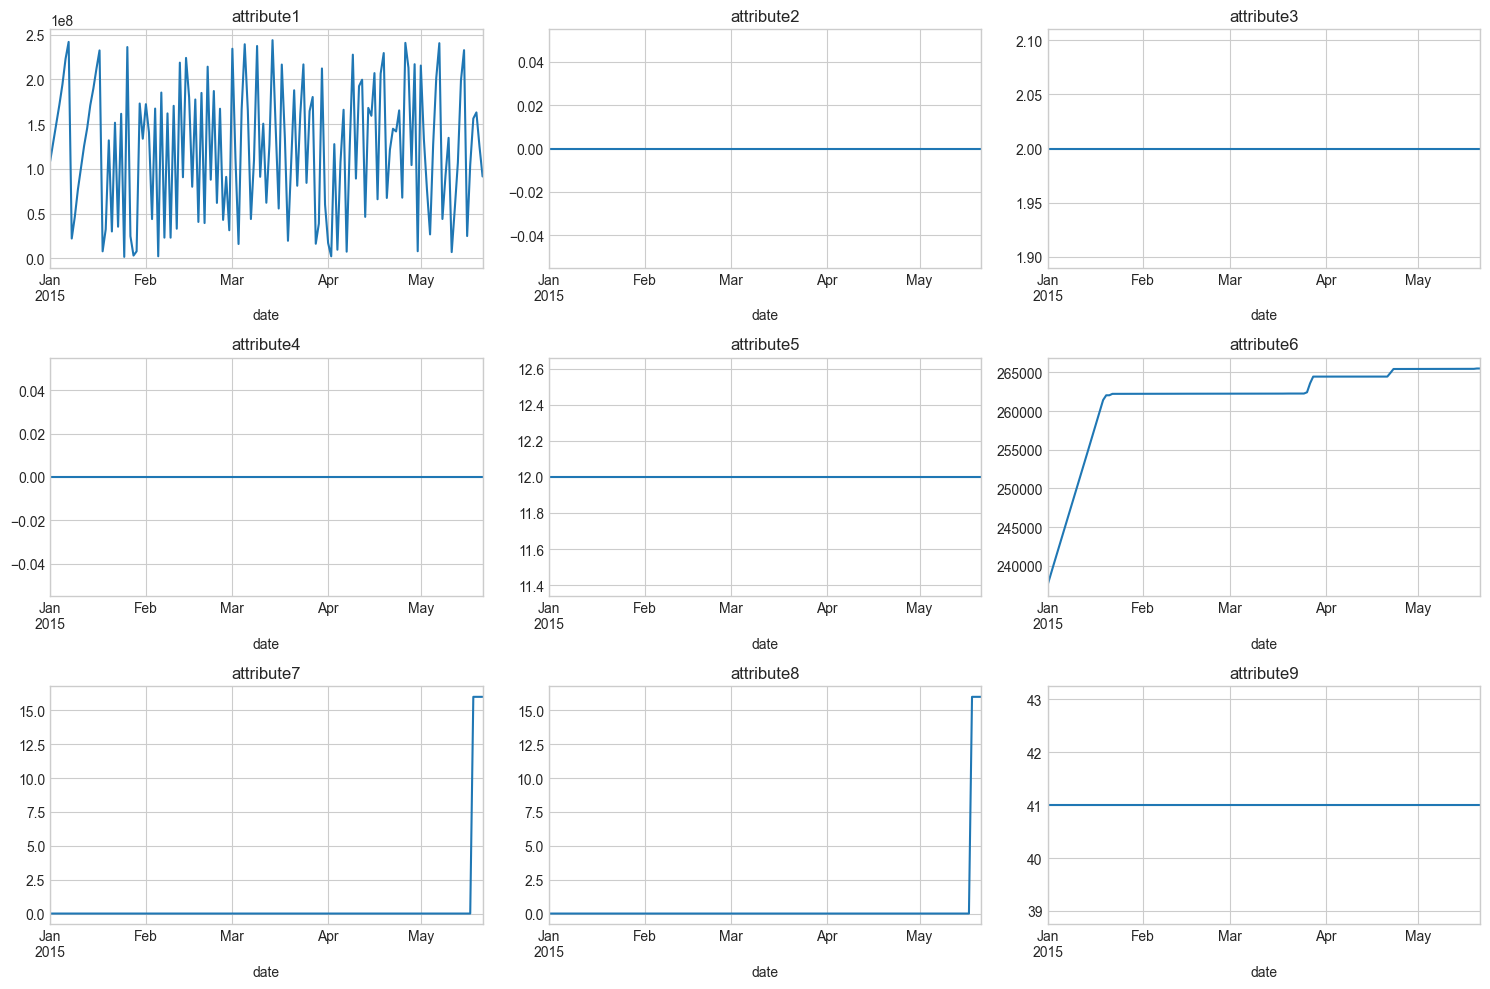

In [31]:
plot_attributes(df, "W1F0WBTM")

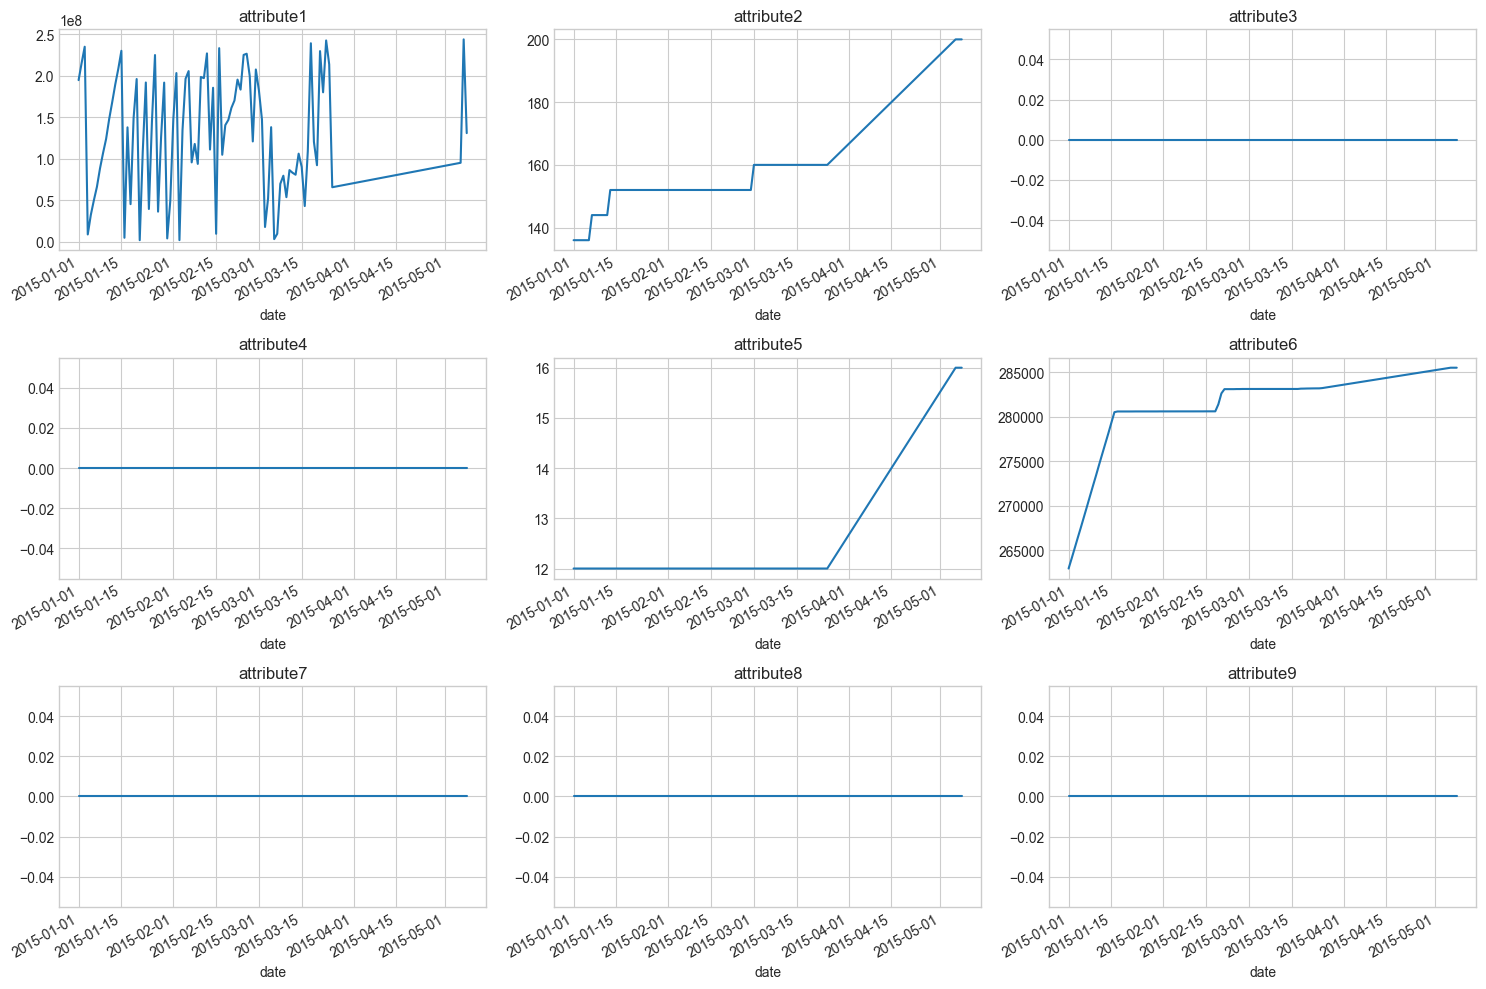

In [32]:
plot_attributes(df, "S1F0RR35")

In [33]:
df = df.drop("attribute8", axis=1)

# Modeling

In [34]:
import mlflow

In [35]:
# mlflow.set_tracking_uri("sqlite:///:memory:")

In [36]:
experiment_name = "failure_prediction"

In [37]:
exps = mlflow.search_experiments(filter_string=f"name = '{experiment_name}'", max_results=1)

In [38]:
if not exps:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = exps[0].experiment_id

## Baseline

In [51]:
X_train, X_test, y_train, y_test = split_data(df, target, test_size=0.2)

In [56]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_baseline"):
    mlflow.xgboost.autolog()
    xgb_baseline = XGBClassifier(eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_baseline.fit(X_train, y_train, eval_set=eval_set, verbose=False)

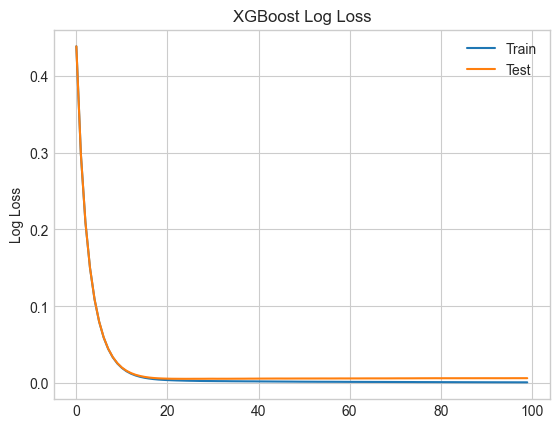

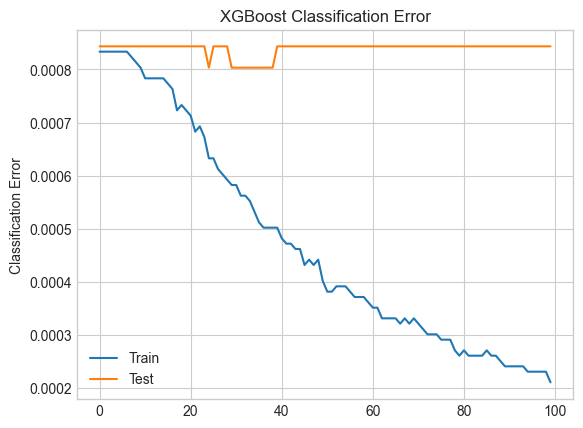

In [58]:
xgb_learning_curves(xgb_baseline)

## Shift 4

In [59]:
# getting window size: the min sequence size
window_size = df.loc[
    df[df[target]==1].index.get_level_values(0).values
].groupby("device").count().min()[target]

In [60]:
cols = [c for c in df.columns if c != target]

X = df.copy()
for col in cols:
    X[f"{col}_min"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).min())
    X[f"{col}_diff_min"] = X[col] - X[f"{col}_min"]
    
    X[f"{col}_max"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).max())
    X[f"{col}_diff_max"] = X[f"{col}_max"] - X[col]
    
    X[f"{col}_mean"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).mean())
    X[f"{col}_diff_mean"] = X[col] - X[f"{col}_mean"]
    
    X[f"{col}_std"] = X[col].groupby(level="device").apply(lambda x: x.rolling(window=window_size).std())
    X[f"{col}_diff_std"] = X[col] - X[f"{col}_std"]
    
    for i in range(1, window_size):
        X[f"{col}_lag{i}"] = X.groupby("device")[col].shift(i)
    X = X.copy()

In [61]:
X = X.dropna()
# X = X.fillna(-1.0)

In [62]:
X.shape

(119821, 105)

In [63]:
X.loc[["S1F0RRB1", "S1F0CTDN", "W1F0PNA5"]][[
    target, "attribute1", "attribute1_lag1", "attribute1_lag2", "attribute1_lag3", "attribute1_lag4", 
    "attribute1_mean", "attribute1_diff_mean", "attribute1_std", "attribute1_diff_std", 
    "attribute1_min", "attribute1_diff_min", "attribute1_max", "attribute1_diff_max"]]

failure   attribute1  attribute1_lag1  attribute1_lag2  \
device   date                                                                 
S1F0RRB1 2015-01-05        1   48467332.0       37985862.0       26258330.0   
S1F0CTDN 2015-01-05        0  134261688.0      112311608.0       91492168.0   
         2015-01-06        0  159974064.0      134261688.0      112311608.0   
         2015-01-07        1  184069720.0      159974064.0      134261688.0   
W1F0PNA5 2015-01-05        0   38285364.0       14442703.0      234878700.0   
         2015-01-06        0   65311277.0       38285364.0       14442703.0   
         2015-01-07        0   88355682.0       65311277.0       38285364.0   
         2015-01-08        0  111562891.0       88355682.0       65311277.0   
         2015-01-09        1  136429411.0      111562891.0       88355682.0   

                     attribute1_lag3  attribute1_lag4  attribute1_mean  \
device   date                                                            
S1F0RRB1 2015-01-05       13307628.0        5230888.0       26250008.0   
S1F0CTDN 2015-01-05       72104024.0       50147888.0       92063475.2   
         2015-01-06       91492168.0       72104024.0      114028710.4   
         2015-01-07      112311608.0       91492168.0      136421849.6   
W1F0PNA5 2015-01-05      211326211.0      185403491.0      136867293.8   
         2015-01-06      234878700.0      211326211.0      112848851.0   
         2015-01-07       14442703.0      234878700.0       88254745.2   
         2015-01-08       38285364.0       14442703.0       63591583.4   
         2015-01-09       65311277.0       38285364.0       87988925.0   

                     attribute1_diff_mean  attribute1_std  \
device   date                                               
S1F0RRB1 2015-01-05            22217324.0    1.761142e+07   
S1F0CTDN 2015-01-05            42198212.8    3.296323e+07   
         2015-01-06            45945353.6    3.460084e+07   
         2015-01-07            47647870.4    3.684316e+07   
W1F0PNA5 2015-01-05           -98581929.8    1.027282e+08   
         2015-01-06           -47537574.0    1.025821e+08   
         2015-01-07              100936.8    8.655945e+07   
         2015-01-08            47971307.6    3.864415e+07   
         2015-01-09            48440486.0    3.836361e+07   

                     attribute1_diff_std  attribute1_min  attribute1_diff_min  \
device   date                                                                   
S1F0RRB1 2015-01-05         3.085591e+07       5230888.0           43236444.0   
S1F0CTDN 2015-01-05         1.012985e+08      50147888.0           84113800.0   
         2015-01-06         1.253732e+08      72104024.0           87870040.0   
         2015-01-07         1.472266e+08      91492168.0           92577552.0   
W1F0PNA5 2015-01-05        -6.444280e+07      14442703.0           23842661.0   
         2015-01-06        -3.727086e+07      14442703.0           50868574.0   
         2015-01-07         1.796232e+06      14442703.0           73912979.0   
         2015-01-08         7.291874e+07      14442703.0           97120188.0   
         2015-01-09         9.806580e+07      38285364.0           98144047.0   

                     attribute1_max  attribute1_diff_max  
device   date                                             
S1F0RRB1 2015-01-05      48467332.0                  0.0  
S1F0CTDN 2015-01-05     134261688.0                  0.0  
         2015-01-06     159974064.0                  0.0  
         2015-01-07     184069720.0                  0.0  
W1F0PNA5 2015-01-05     234878700.0          196593336.0  
         2015-01-06     234878700.0          169567423.0  
         2015-01-07     234878700.0          146523018.0  
         2015-01-08     111562891.0                  0.0  
         2015-01-09     136429411.0                  0.0

In [64]:
# split data based on device ids
X_train, X_test, y_train, y_test = split_data_on_index(X, target, index_level=0)

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train = np.clip(X_train, -5, 5)
# X_test = np.clip(X_test, -5, 5)

In [66]:
from collections import Counter
counter = Counter(X[target])
scale_pos_weight = round(counter[0] / counter[1], 0)
counter[0], counter[1], scale_pos_weight

(119715, 106, 1129.0)

In [74]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

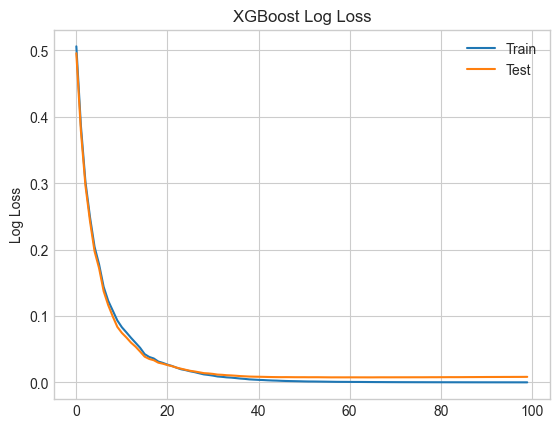

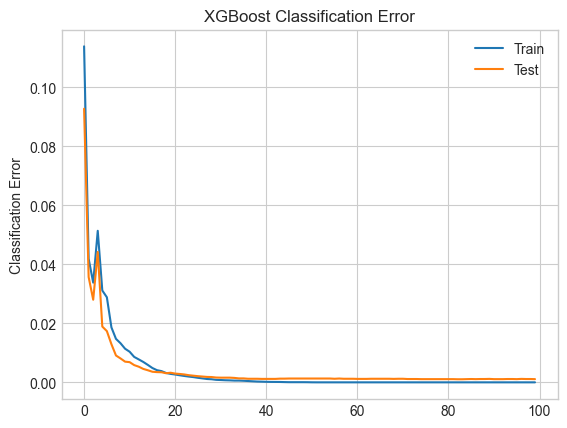

In [75]:
xgb_learning_curves(xgb_lags)

In [80]:
y_pred_train = xgb_lags.predict(X_train)
y_pred_test = xgb_lags.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95769
           1       1.00      1.00      1.00        87

    accuracy                           1.00     95856
   macro avg       1.00      1.00      1.00     95856
weighted avg       1.00      1.00      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.11      0.05      0.07        19

    accuracy                           1.00     23965
   macro avg       0.56      0.53      0.54     23965
weighted avg       1.00      1.00      1.00     23965



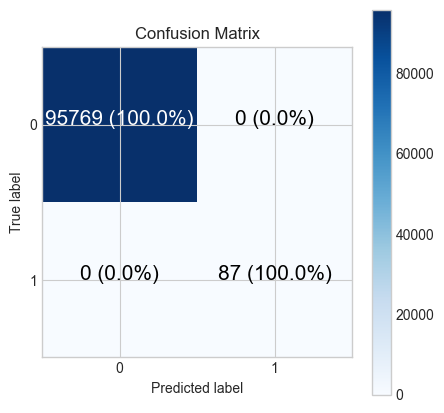

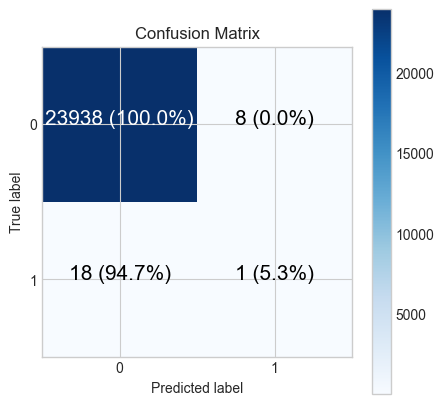

In [83]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [84]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.6,
        subsample=0.6,
        max_depth=5,
        gamma=4,
        n_estimators=300,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

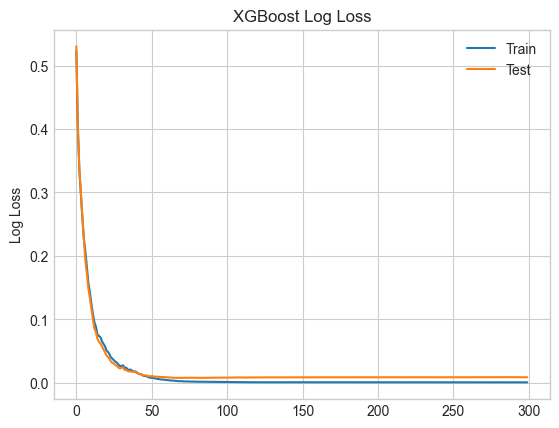

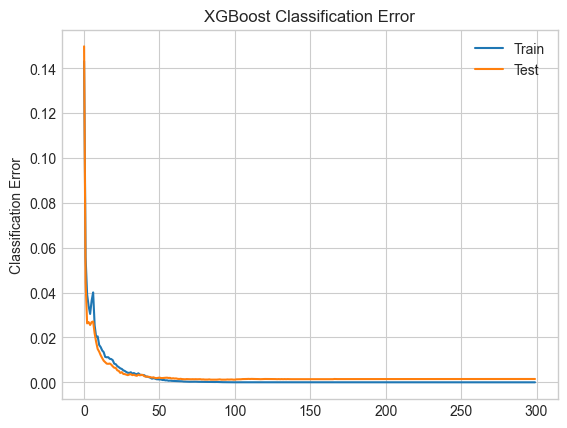

In [85]:
xgb_learning_curves(xgb_lags)

In [86]:
y_pred_train = xgb_lags.predict(X_train)
y_pred_test = xgb_lags.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95769
           1       0.98      1.00      0.99        87

    accuracy                           1.00     95856
   macro avg       0.99      1.00      0.99     95856
weighted avg       1.00      1.00      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.10      0.11      0.10        19

    accuracy                           1.00     23965
   macro avg       0.55      0.55      0.55     23965
weighted avg       1.00      1.00      1.00     23965



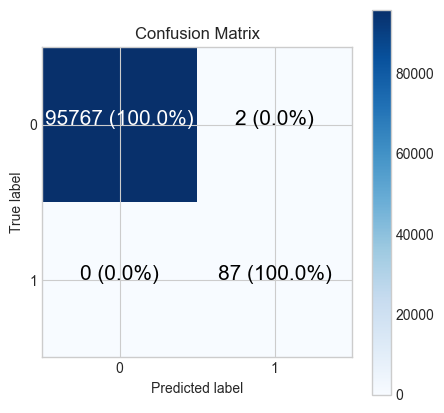

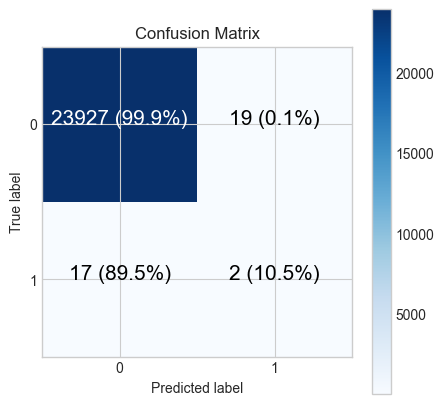

In [87]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [88]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.7,
        subsample=0.7,
        max_depth=4,
        gamma=4,
        n_estimators=300,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

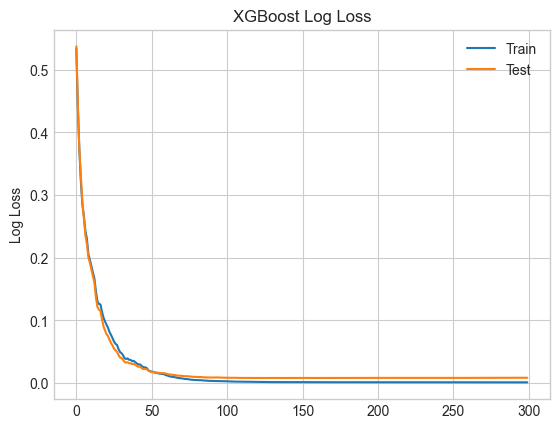

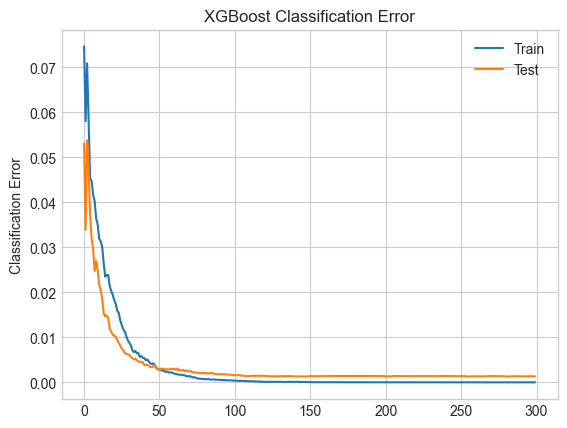

In [89]:
xgb_learning_curves(xgb_lags)

In [90]:
y_pred_train = xgb_lags.predict(X_train)
y_pred_test = xgb_lags.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95769
           1       1.00      1.00      1.00        87

    accuracy                           1.00     95856
   macro avg       1.00      1.00      1.00     95856
weighted avg       1.00      1.00      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.07      0.05      0.06        19

    accuracy                           1.00     23965
   macro avg       0.53      0.53      0.53     23965
weighted avg       1.00      1.00      1.00     23965



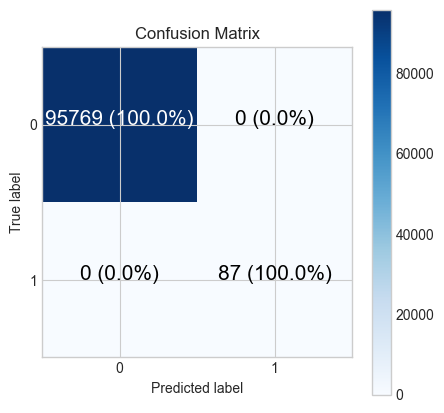

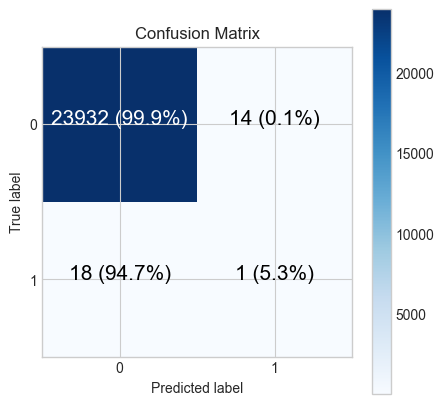

In [91]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [92]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.5,
        subsample=0.5,
        max_depth=6,
        gamma=4,
        n_estimators=300,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

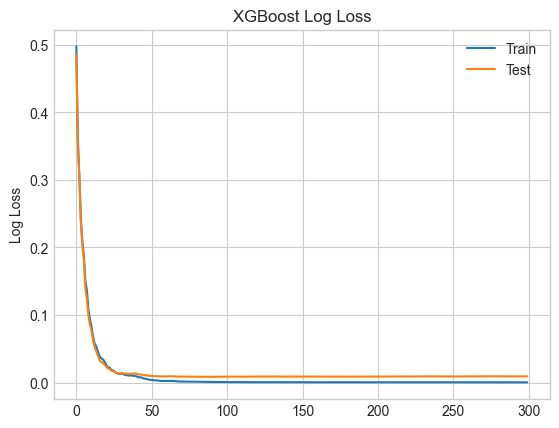

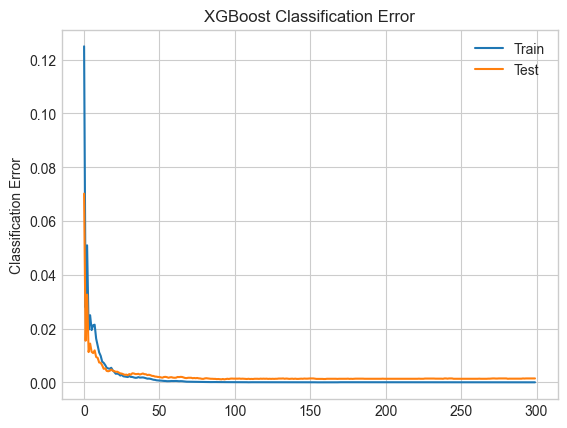

In [93]:
xgb_learning_curves(xgb_lags)

In [94]:
y_pred_train = xgb_lags.predict(X_train)
y_pred_test = xgb_lags.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95769
           1       0.98      1.00      0.99        87

    accuracy                           1.00     95856
   macro avg       0.99      1.00      0.99     95856
weighted avg       1.00      1.00      1.00     95856

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23946
           1       0.10      0.11      0.10        19

    accuracy                           1.00     23965
   macro avg       0.55      0.55      0.55     23965
weighted avg       1.00      1.00      1.00     23965



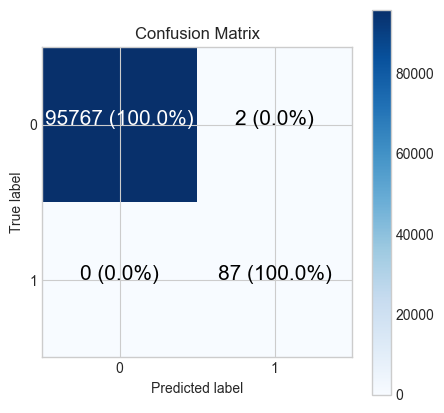

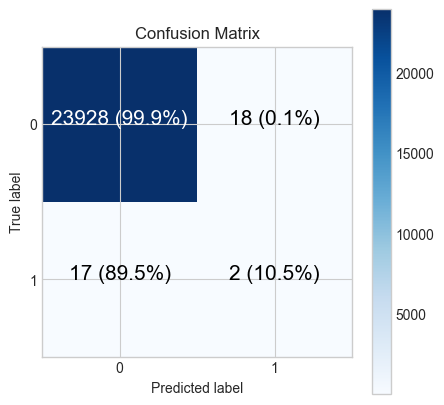

In [95]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [104]:
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_score #, GridSearchCV, RandomizedSearchCV

In [110]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.3]),
    'max_depth' : hp.choice('max_depth', range(3,7)),
    'gamma' : hp.choice('gamma', [1,2,4,6]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'subsample' : hp.choice('subsample', [i/10.0 for i in range(3,10)]),
    'scale_pos_weight' : hp.choice('scale_pos_weight', [scale_pos_weight*i for i in np.arange(0.8, 1.2, 0.1)]),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 50))
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [111]:
# Objective function
def objective(params):
    xgboost = XGBClassifier(seed=0, **params)
    score = cross_val_score(estimator=xgboost, 
                            X=X_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='recall', 
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = - score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [112]:
%time
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags_hyperopt"):
    mlflow.xgboost.autolog()

    # Optimize
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())
    
    # Print the index of the best parameters
    print(best)
    # Print the values of the best parameters
    print(space_eval(space, best))
    
    # Train model using the best parameters
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_lags_opt = XGBClassifier(seed=0, 
                                 learning_rate=space_eval(space, best)['learning_rate'], 
                                 max_depth=space_eval(space, best)['max_depth'],
                                 gamma=space_eval(space, best)['gamma'], 
                                 colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                                 subsample=space_eval(space, best)['subsample'], 
                                 scale_pos_weight=space_eval(space, best)['scale_pos_weight'],
                                 eval_metric=['error', 'logloss']
                                ).fit(X_train,y_train, eval_set=eval_set, verbose=False)
    
    # # Make prediction using the best model
    # bayesian_opt_predict = xgboost_bo.predict(X_test)
    # # Get predicted probabilities
    # bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test_transformed)[:,1]
    # # Get performance metrics
    # precision, recall, fscore, support = score(y_test, bayesian_opt_predict)
    # # Print result
    # print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

#     xgb_lags = XGBClassifier(
#         scale_pos_weight=scale_pos_weight,
#         colsample_bytree=0.5,
#         subsample=0.5,
#         max_depth=6,
#         gamma=4,
#         n_estimators=300)
    
#     xgb_lags.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 925 µs
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [2:36:13<00:00, 195.28s/trial, best loss: -0.6091954022988505]
{'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0, 'max_depth': 0, 'n_estimators': 13, 'scale_pos_weight': 2, 'subsample': 6}
{'colsample_bytree': 0.4, 'gamma': 6, 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 750, 'scale_pos_weight': 1129.0, 'subsample': 0.9}


In [113]:
space_eval(space, best)

{'colsample_bytree': 0.4,
 'gamma': 6,
 'learning_rate': 0.001,
 'max_depth': 3,
 'n_estimators': 750,
 'scale_pos_weight': 1129.0,
 'subsample': 0.9}

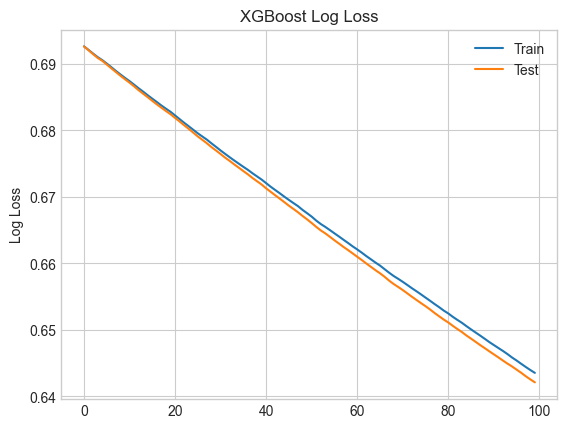

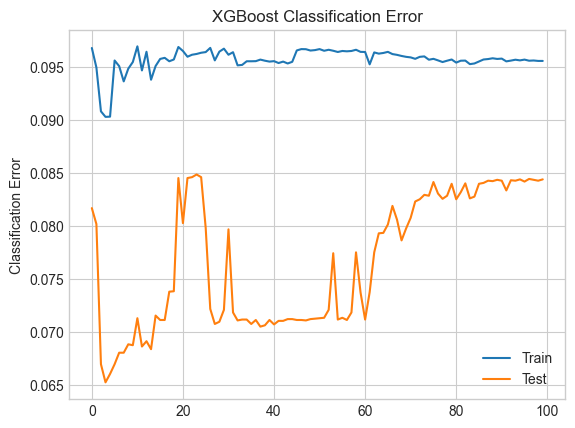

In [114]:
xgb_learning_curves(xgb_lags_opt)

In [115]:
y_pred_train = xgb_lags_opt.predict(X_train)
y_pred_test = xgb_lags_opt.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     95769
           1       0.01      0.82      0.02        87

    accuracy                           0.90     95856
   macro avg       0.50      0.86      0.48     95856
weighted avg       1.00      0.90      0.95     95856

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     23946
           1       0.01      0.63      0.01        19

    accuracy                           0.92     23965
   macro avg       0.50      0.77      0.48     23965
weighted avg       1.00      0.92      0.96     23965



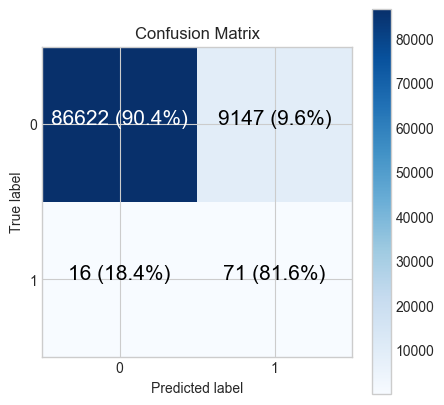

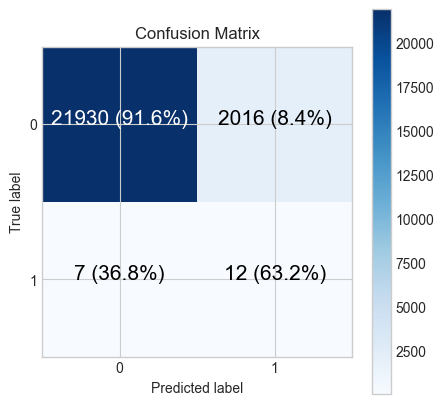

In [116]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [140]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags_ho_lr"):
    mlflow.xgboost.autolog()
    xgb = XGBClassifier(
        seed=0,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.4,
        subsample=0.9,
        max_depth=3,
        gamma=6,
        n_estimators=1500,
        learning_rate=0.001,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

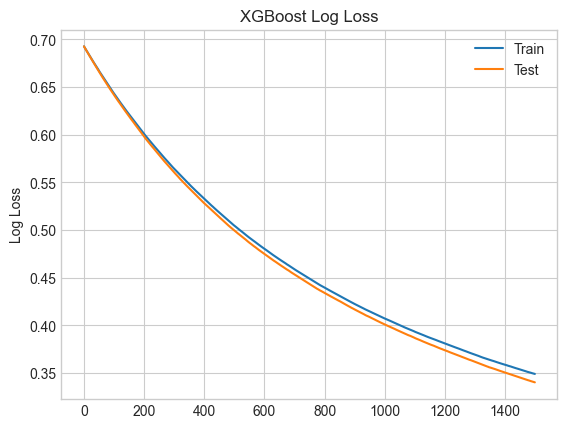

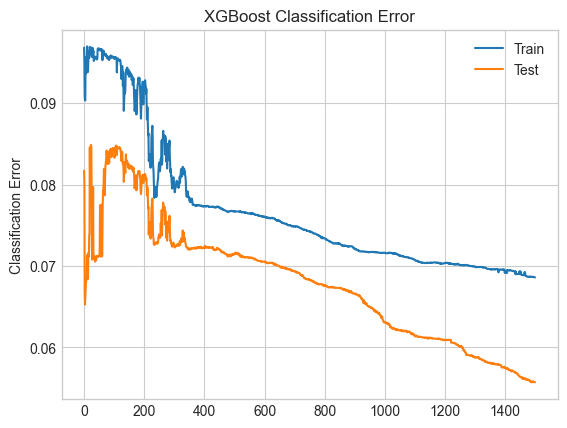

In [141]:
xgb_learning_curves(xgb)

In [142]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     95769
           1       0.01      0.82      0.02        87

    accuracy                           0.93     95856
   macro avg       0.51      0.87      0.49     95856
weighted avg       1.00      0.93      0.96     95856

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     23946
           1       0.01      0.63      0.02        19

    accuracy                           0.94     23965
   macro avg       0.50      0.79      0.49     23965
weighted avg       1.00      0.94      0.97     23965



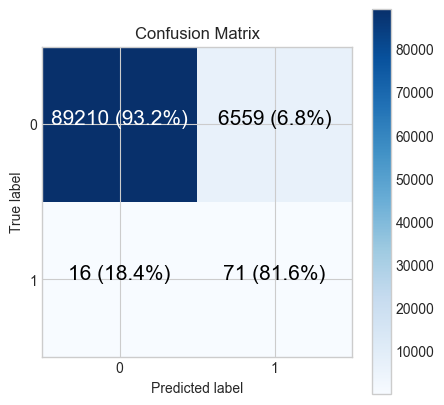

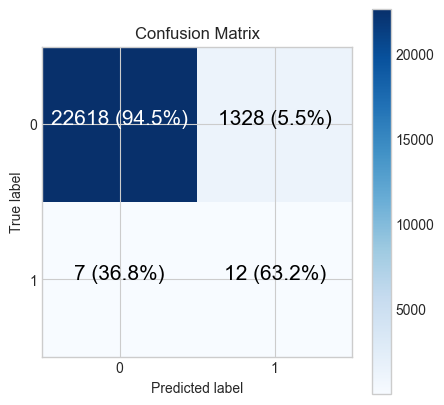

In [143]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [144]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags_ho_lr"):
    mlflow.xgboost.autolog()
    xgb = XGBClassifier(
        seed=0,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.4,
        subsample=0.9,
        max_depth=3,
        gamma=6,
        n_estimators=3000,
        learning_rate=0.001,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

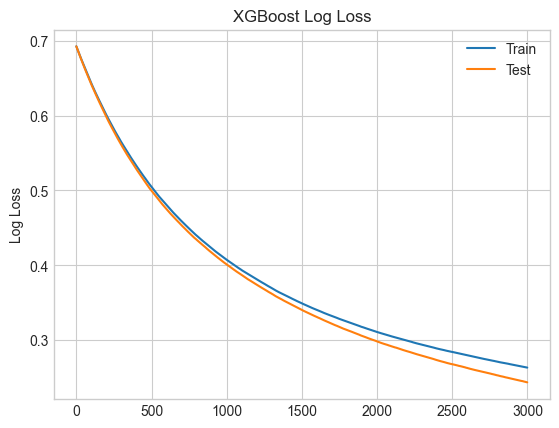

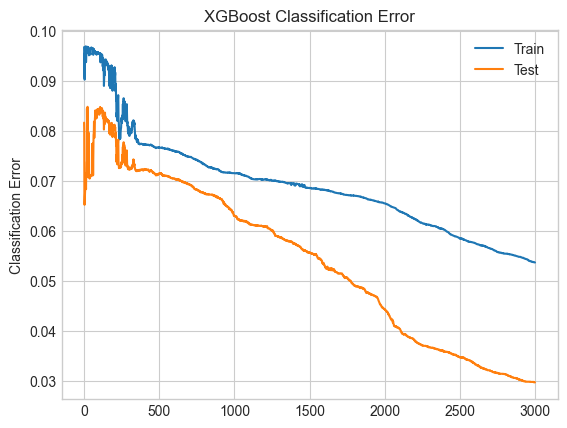

In [145]:
xgb_learning_curves(xgb)

In [146]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     95769
           1       0.01      0.83      0.03        87

    accuracy                           0.95     95856
   macro avg       0.51      0.89      0.50     95856
weighted avg       1.00      0.95      0.97     95856

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     23946
           1       0.01      0.53      0.03        19

    accuracy                           0.97     23965
   macro avg       0.51      0.75      0.51     23965
weighted avg       1.00      0.97      0.98     23965



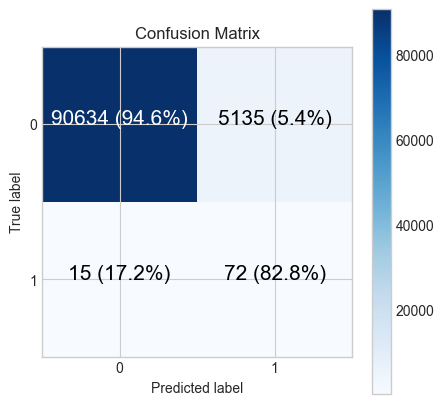

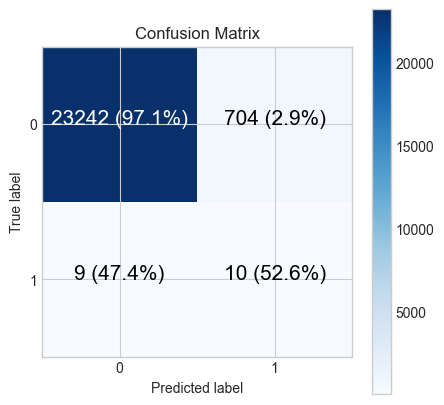

In [147]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [148]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags_ho_lr"):
    mlflow.xgboost.autolog()
    xgb = XGBClassifier(
        seed=0,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.4,
        subsample=0.9,
        max_depth=3,
        gamma=6,
        n_estimators=5000,
        learning_rate=0.001,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

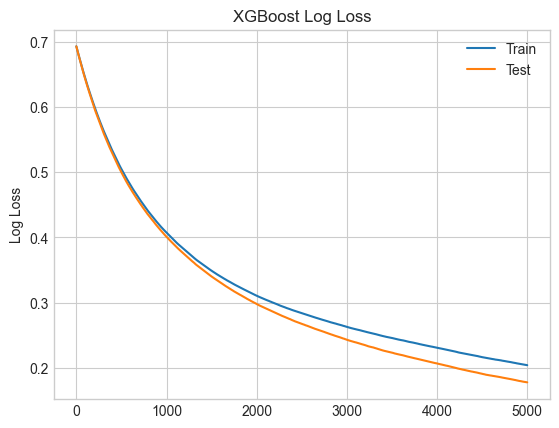

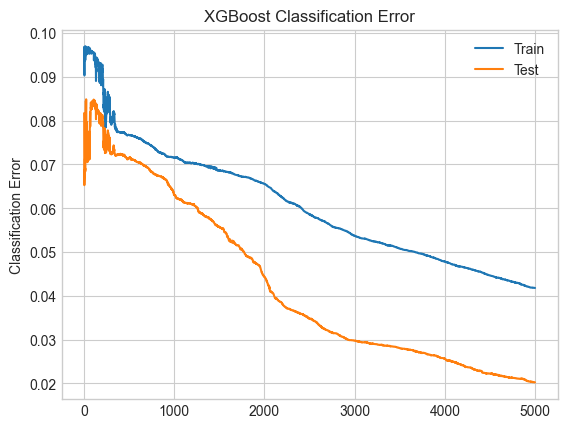

In [149]:
xgb_learning_curves(xgb)

In [150]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     95769
           1       0.02      0.91      0.04        87

    accuracy                           0.96     95856
   macro avg       0.51      0.93      0.51     95856
weighted avg       1.00      0.96      0.98     95856

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23946
           1       0.02      0.47      0.04        19

    accuracy                           0.98     23965
   macro avg       0.51      0.73      0.51     23965
weighted avg       1.00      0.98      0.99     23965



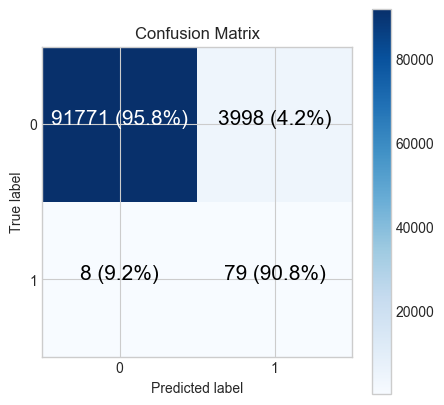

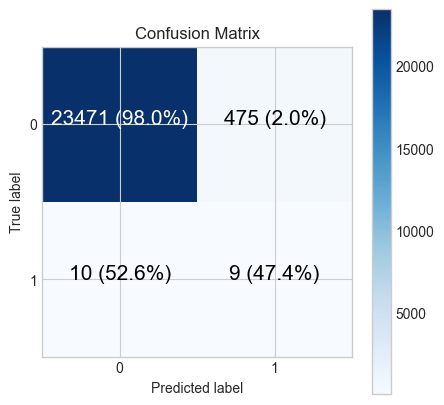

In [151]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

In [152]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_4_lags_ho_lr"):
    mlflow.xgboost.autolog()
    xgb = XGBClassifier(
        seed=0,
        scale_pos_weight=scale_pos_weight,
        colsample_bytree=0.4,
        subsample=0.9,
        max_depth=3,
        gamma=6,
        n_estimators=10000,
        learning_rate=0.0001,
        eval_metric=['error', 'logloss'])
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

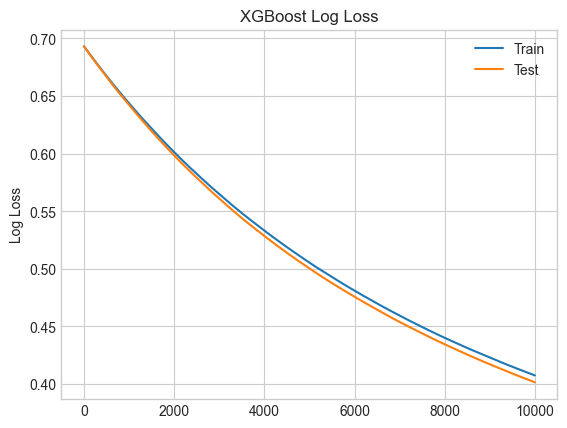

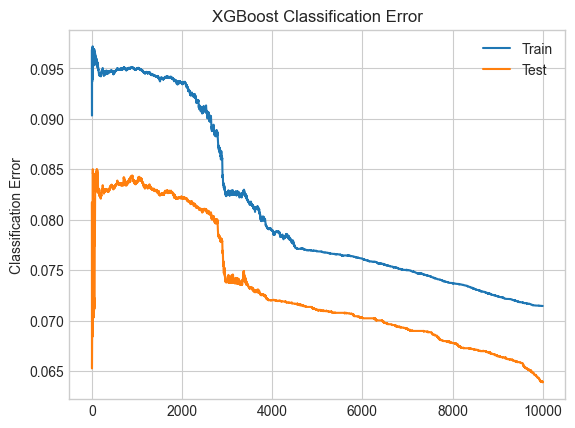

In [153]:
xgb_learning_curves(xgb)

In [154]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     95769
           1       0.01      0.82      0.02        87

    accuracy                           0.93     95856
   macro avg       0.51      0.87      0.49     95856
weighted avg       1.00      0.93      0.96     95856

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     23946
           1       0.01      0.63      0.02        19

    accuracy                           0.94     23965
   macro avg       0.50      0.78      0.49     23965
weighted avg       1.00      0.94      0.97     23965



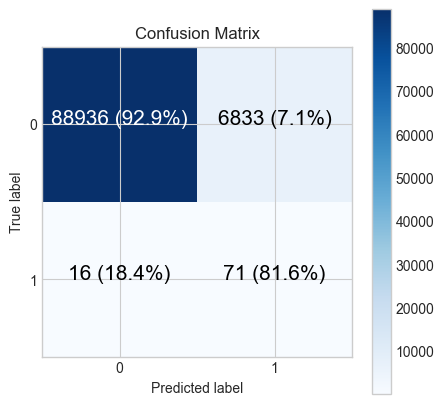

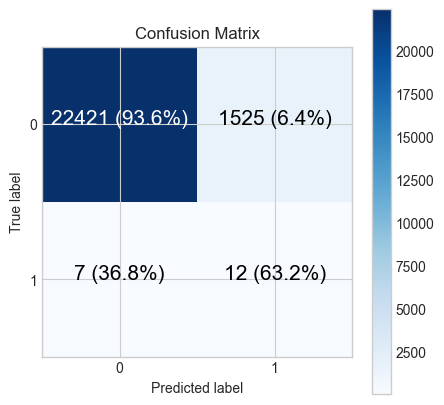

In [155]:
make_confusion_matrix(y_train, y_pred_train, figsize=(5,5))
make_confusion_matrix(y_test, y_pred_test, figsize=(5,5))

## shift 10

In [ ]:
cols = [c for c in df.columns if "_lag" not in c and c != target]

for i in range(5, 10):
    for col in cols:
        df[f"{col}_lag{i}"] = df.groupby("device")[col].shift(i)
    df = df.copy()

In [ ]:
df = df.fillna(-1.0)

In [ ]:
df.shape

In [ ]:
df.loc[["S1F0RRB1", "S1F0CTDN", "W1F0PNA5"]][[
    "attribute1", "attribute1_lag5", "attribute1_lag6", "attribute1_lag7", "attribute1_lag8", "attribute1_lag9"]]

In [ ]:
# split data based on device ids
X_train, X_test, y_train, y_test = split_data_on_index(df, target, index_level=0)

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name="xgboost_9_lags"):
    mlflow.xgboost.autolog()
    xgb_lags = XGBClassifier()
    # score_model(xgb_lags, X_train, y_train, scoring='recall')

## LSTM

In [ ]:
# cols = [c for c in X_train.columns if "_lag" not in c and c != target]

# X = []
# for col in cols:
#     arr_cols = [col]
#     for i in range(1, 5):
#         arr_cols.append(f"{col}_lag{i}")
#     X.append(X_train[arr_cols].values)
    
# X_train = np.array(list(zip(X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7])))

# cols = [c for c in X_test.columns if "_lag" not in c and c != target]

# X = []
# for col in cols:
#     arr_cols = [col]
#     for i in range(1, 5):
#         arr_cols.append(f"{col}_lag{i}")
#     X.append(X_test[arr_cols].values)
    
# X_test = np.array(list(zip(X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7])))

# X_train.shape, X_test.shape

In [ ]:
cols = [c for c in X_train.columns if "_lag" not in c and c != target]

# X_train = X_train.replace(-1, np.nan).dropna()
X = []
for i in range(5):
    arr_cols = []
    for col in cols:
        if i == 0:
            arr_cols.append(col)
        else:
            arr_cols.append(f"{col}_lag{i}")
    X.append(X_train[arr_cols].values)
    
X_train = np.array(list(zip(X[0], X[1], X[2], X[3], X[4])))

In [ ]:
cols = [c for c in X_test.columns if "_lag" not in c and c != target]

X = []
for i in range(5):
    arr_cols = []
    for col in cols:
        if i == 0:
            arr_cols.append(col)
        else:
            arr_cols.append(f"{col}_lag{i}")
    X.append(X_test[arr_cols].values)
    
X_test = np.array(list(zip(X[0], X[1], X[2], X[3], X[4]))) #, X[5], X[6], X[7])))

In [ ]:
X_train.shape, X_test.shape

In [ ]:
# cols = [c for c in X_train.columns if "_lag" not in c and c != target]

# selected_cols = []
# for col in cols:
#     selected_cols.append(col)
#     for i in range(1, 5):
#         selected_cols.append(f"{col}_lag{i}")

# X_train = X_train[selected_cols].to_numpy()
# X_test = X_test[selected_cols].to_numpy()

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train = np.clip(X_train, -5, 5)
X_test = np.clip(X_test, -5, 5)

In [ ]:
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(64, activation="relu", return_sequences=True)(inputs)
x = layers.LSTM(32, activation="relu", return_sequences=True)(x)
x = layers.LSTM(16, activation="relu", return_sequences=True)(x)
x = layers.LSTM(4, activation="relu")(x)
x = layers.RepeatVector(X_train.shape[1])(x)
x = layers.LSTM(4, activation="relu", return_sequences=True)(x)
x = layers.LSTM(16, activation="relu", return_sequences=True)(x)
x = layers.LSTM(32, activation="relu", return_sequences=True)(x)
x = layers.LSTM(64, activation="relu", return_sequences=True)(x)
# x = layers.LSTM(16, activation="relu")(x)
# outputs = layers.TimeDistributed(layers.Dense(X_train.shape[2]))(x)
x = layers.TimeDistributed(layers.Dense(X_train.shape[2]))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
lstm_4_lags = keras.Model(inputs, outputs, name="LSTM_4_lags")

lstm_4_lags.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                    metrics=[
                        keras.metrics.TruePositives(name='tp'),
                        keras.metrics.FalsePositives(name='fp'),
                        keras.metrics.TrueNegatives(name='tn'),
                        keras.metrics.FalseNegatives(name='fn'), 
                        keras.metrics.BinaryAccuracy(name='accuracy'),
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall'),
                        keras.metrics.AUC(name='auc'),
                        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                    ])

lstm_4_lags.summary()

In [ ]:
with mlflow.start_run(experiment_id=experiment_id, run_name="LSTM_4_lags"):
    mlflow.tensorflow.autolog()
    lstm_4_lags.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test))